### Import required Libraries

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import gym
import deap
from stable_baselines3 import PPO

### 1. Create Sample Shelves Dataset

In [17]:
# Sample shelves dataset (20 shelves with random coordinates)
shelves_data = {
    'Shelf_ID': [f'S{i+1}' for i in range(20)],
    'Location_X': np.random.randint(0, 100, size=20),
    'Location_Y': np.random.randint(0, 100, size=20),
    'Total_Items': np.random.randint(10, 30, size=20),
}

In [18]:
# Create DataFrame
shelves_df = pd.DataFrame(shelves_data)

# Print shelves DataFrame
print(shelves_df)

   Shelf_ID  Location_X  Location_Y  Total_Items
0        S1          37          90           14
1        S2          43          21           29
2        S3          42          50           28
3        S4          85          30           18
4        S5          81          62           10
5        S6          45          25           27
6        S7          64          30           14
7        S8          59          88           24
8        S9          61          68           13
9       S10           6          15           18
10      S11           1          27           16
11      S12          67          96           14
12      S13          50          45           19
13      S14          76          14           29
14      S15          42          77           27
15      S16          70           8           13
16      S17          74          40           12
17      S18           5           2           23
18      S19          29          28           24
19      S20         

### 2. Create a NumPy array for shelf locations

In [19]:
shelves_locations = shelves_df[['Location_X', 'Location_Y']].to_numpy()

### 3. Define the Distance Matrix Function

In [20]:
def shelf_distance(s1, s2):
    if not (0 <= s1 < len(shelves_locations)) or not (0 <= s2 < len(shelves_locations)):
        raise IndexError(f"Invalid index: s1={s1}, s2={s2} for shelves_locations with size {len(shelves_locations)}")

    return np.linalg.norm(shelves_locations[s1] - shelves_locations[s2])

In [21]:
# Create a distance matrix
num_shelves = len(shelves_locations)
distance_matrix = np.zeros((num_shelves, num_shelves))

for i in range(num_shelves):
    for j in range(num_shelves):
        distance_matrix[i][j] = shelf_distance(i, j)

# Print distance matrix
print("Distance Matrix:\n", distance_matrix)

Distance Matrix:
 [[  0.          69.26037828  40.31128874  76.83749085  52.15361924
   65.49045732  65.7951366   22.09072203  32.55764119  81.15417426
   72.56031973  30.59411708  46.84015371  85.42247948  13.92838828
   88.39117603  62.20128616  93.63759929  62.51399843  48.50773134]
 [ 69.26037828   0.          29.01723626  42.95346319  55.90169944
    4.47213595  22.84731932  68.8839604   50.32891813  37.48332963
   42.42640687  78.74642849  25.          33.73425559  56.00892786
   29.96664813  36.35931793  42.48529157  15.65247584  21.02379604]
 [ 40.31128874  29.01723626   0.          47.42362281  40.80441153
   25.17935662  29.73213749  41.62931659  26.17250466  50.20956084
   47.01063709  52.35456045   9.43398113  49.51767361  27.
   50.47771786  33.52610923  60.6052803   25.55386468   8.24621125]
 [ 76.83749085  42.95346319  47.42362281   0.          32.24903099
   40.31128874  21.          63.56099433  44.94441011  80.41144197
   84.05355436  68.41052551  38.07886553  18.3575

### 4. Implement the Ant Colony Optimization Class

In [22]:
class AntColony:
    def __init__(self, distance_matrix, n_ants, n_best, n_iterations, decay, alpha=1, beta=1):
        self.distances = distance_matrix
        self.pheromone = np.ones(self.distances.shape) / len(distance_matrix)
        self.all_inds = range(len(distance_matrix))
        self.n_ants = n_ants
        self.n_best = n_best
        self.n_iterations = n_iterations
        self.decay = decay
        self.alpha = alpha
        self.beta = beta

    def run(self):
        all_time_shortest_path = ("placeholder", np.inf)
        for _ in range(self.n_iterations):
            all_paths = self.gen_all_paths()
            self.spread_pheromone(all_paths, self.n_best)
            shortest_path = min(all_paths, key=lambda x: x[1])  # x[1] is the distance
            if shortest_path[1] < all_time_shortest_path[1]:
                all_time_shortest_path = shortest_path
            self.pheromone *= self.decay  # Apply decay
        return all_time_shortest_path

    def spread_pheromone(self, all_paths, n_best):
        sorted_paths = sorted(all_paths, key=lambda x: x[1])  # Sort based on distance
        for path, dist in sorted_paths[:n_best]:  # Take n_best paths
            for move in path:
                self.pheromone[move] += 1.0 / self.distances[move]

    def gen_path_dist(self, path):
        total_dist = 0
        for i in range(len(path) - 1):
            total_dist += self.distances[path[i]][path[i + 1]]  # Compute distance from current to next
        return total_dist

    def gen_all_paths(self):
        all_paths = []
        for _ in range(self.n_ants):
            path = self.gen_path(0)  # Start at shelf 0
            path_distance = self.gen_path_dist(path)
            all_paths.append((path, path_distance))  # Append path and its distance
        return all_paths

    def gen_path(self, start):
        path = []
        visited = set()
        visited.add(start)
        prev = start
        for _ in range(len(self.distances) - 1):
            move = self.pick_move(self.pheromone[prev], self.distances[prev], visited)
            path.append(move)
            prev = move
            visited.add(move)
        path.append(start)  # Returning to start
        return path

    def pick_move(self, pheromone, dist, visited):
        pheromone = np.copy(pheromone)
        pheromone[list(visited)] = 0  # Block visited nodes

        # Avoid division by zero
        dist = np.where(dist == 0, np.inf, dist)

        row = pheromone ** self.alpha * ((1.0 / dist) ** self.beta)

        if np.sum(row) == 0:
            return np.random.choice(list(set(self.all_inds) - visited))

        norm_row = row / row.sum()
        move = np.random.choice(list(self.all_inds), p=norm_row)
        return move

### 5. Initialize and Run the Ant Colony Optimization

In [23]:
aco = AntColony(distance_matrix, n_ants=5, n_best=2, n_iterations=100, decay=0.95)
best_shelf_route = aco.run()

print("Best shelf route:", best_shelf_route)

C:\Users\premd\AppData\Local\Temp\ipykernel_29000\3754780180.py:28: RuntimeWarning: divide by zero encountered in divide
  self.pheromone[move] += 1.0 / self.distances[move]


Best shelf route: ([np.int64(11), np.int64(7), np.int64(4), np.int64(8), np.int64(19), np.int64(2), np.int64(12), np.int64(16), np.int64(6), np.int64(3), np.int64(13), np.int64(15), np.int64(1), np.int64(18), np.int64(5), np.int64(10), np.int64(9), np.int64(17), np.int64(14), 0], np.float64(431.0383207119285))


### 6. Create the Gym Environment for Reinforcement Learning

In [24]:
class WarehouseEnv(gym.Env):
    def __init__(self):
        super(WarehouseEnv, self).__init__()
        # Define action and observation space
        self.action_space = gym.spaces.Discrete(num_shelves)  # Pick a shelf
        self.observation_space = gym.spaces.Box(low=0, high=100, shape=(2,), dtype=np.float32)

    def reset(self):
        self.state = np.zeros(2)  # Reset warehouse state to start position
        return self.state

    def step(self, action):
        # Reward based on distance to shelves
        distance_to_shelf = shelf_distance(int(self.state[0]), action)  # Get distance
        reward = -distance_to_shelf  # Penalize distance
        self.state[0] = action  # Update the current shelf
        done = False  # Indicate whether the episode is done
        return self.state, reward, done, {}

In [25]:
# Create environment
env = WarehouseEnv()

### 7. Train the RL Model

In [26]:
# Create PPO model
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


d:\Academics\20XW58\Robotic-Mobile-Fulfillment-System\venv\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


-----------------------------
| time/              |      |
|    fps             | 1124 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 665           |
|    iterations           | 2             |
|    time_elapsed         | 6             |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 0.008889812   |
|    clip_fraction        | 0.0361        |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.99         |
|    explained_variance   | 2.4795532e-05 |
|    learning_rate        | 0.0003        |
|    loss                 | 2.96e+05      |
|    n_updates            | 10            |
|    policy_gradient_loss | -0.0149       |
|    value_loss           | 5.95e+05      |
------------------------------------------

### 8. Test the trained model

In [27]:
obs = env.reset()
for step in range(100):
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        break

### 9. Visualize best shelf route

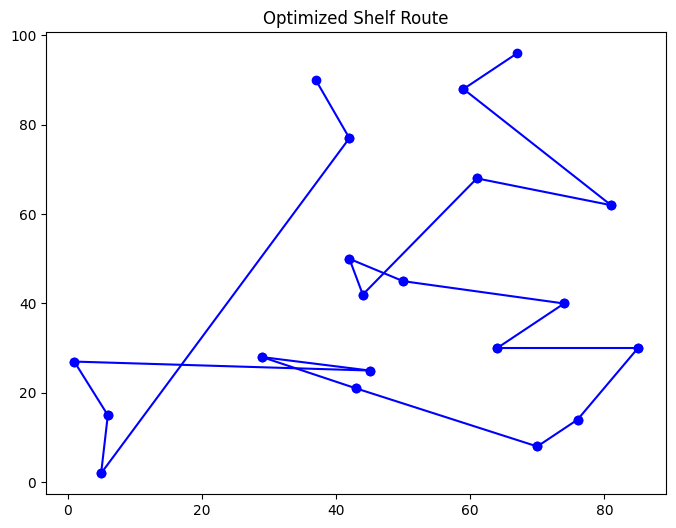

In [28]:
plt.figure(figsize=(8, 6))
for i in range(len(best_shelf_route[0]) - 1):
    x1, y1 = shelves_locations[best_shelf_route[0][i]]
    x2, y2 = shelves_locations[best_shelf_route[0][i + 1]]
    plt.plot([x1, x2], [y1, y2], 'bo-')
plt.title('Optimized Shelf Route')
plt.show()

### 10. Plot robot task completion time

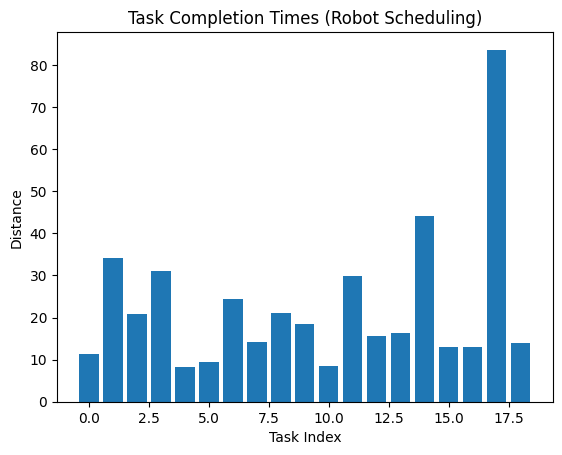

In [29]:
plt.bar(range(len(best_shelf_route[0]) - 1),
        [shelf_distance(best_shelf_route[0][i], best_shelf_route[0][i + 1]) for i in range(len(best_shelf_route[0]) - 1)])
plt.title('Task Completion Times (Robot Scheduling)')
plt.xlabel('Task Index')
plt.ylabel('Distance')
plt.show()